In [1]:
from mcmc.particle_gibbs import ParticleGibbs, PGSamples, PGConfig
from mcmc.rwmh import RandomWalkMH, RWMHConfig, MatrixRWMH, CovarianceRWMH

from feynman_kac.protocol import PFOutputs, PFConfig, FeynmacKac
from feynman_kac.bootstrap import CSMC, PF, BaseParticleFilter, iRWCSMC
from feynman_kac.particle_mala import ParticleAuxiliaryMALA as PaMALA, ParticleMALA as PMALA

from resample.backward_sampling import BaseBackwardSampler, LineageTracking, BackwardSampler

from feynman_kac.model.lgssm import LGSSM_BPF
from utils.datasets import load_dataset

from dynamax.linear_gaussian_ssm import lgssm_filter, lgssm_smoother
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from jax import Array
import jax.random as jr
import jax.numpy as jnp

### Make True Data

In [2]:
def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_filter(params, y)
    print("Exact filter means shape: ", lgssm_posterior.filtered_means.shape)
    return lgssm_posterior

In [3]:
# data
data = load_dataset('linear_large', seed=0)
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 30)


### Define Particle Gibbs class with Metropolis within Hastings parameter updates 

In [4]:
class LinearGaussianParticleGibbs(ParticleGibbs):
    """
    Run Particle Gibbs on LGSSM
    """
    def __init__(self, pf: BaseParticleFilter, cfg: PGConfig, backward_sampler: BaseBackwardSampler, samplers: list):
        super().__init__(pf, cfg, backward_sampler)
        self.samplers = samplers
    
    def update_params(self, key, curr_params: dict, outs: PFOutputs, obs: Array, ref: Array):

        new_params = {}
        
        for sampler in self.samplers:
            key, subkey = jr.split(key)
            curr = curr_params.get(sampler.cfg.name)
            key, new  = sampler.sample(subkey, curr, self.pf.model, ref, obs)
            new_params[sampler.cfg.name] = new
        return new_params
        

In [5]:
# param names should match those of params in the used model
A_cfg = RWMHConfig(name="A", scale=0.00000001, n_burn=500, adaptive=True)
C_cfg = RWMHConfig(name="C", scale=0.2, n_burn=500, adaptive=True)
Q_cfg = RWMHConfig(name="Q", scale=0.2, n_burn=500, adaptive=True)
R_cfg = RWMHConfig(name="R", scale=0.2, n_burn=500, adaptive=True)

# Random Walk samplers
A_rwmh = MatrixRWMH(A_cfg, means=jnp.eye(1), sigma=2)
C_rwmh = MatrixRWMH(C_cfg, means=0.5*jnp.eye(1), sigma=2)
Q_rwmh = CovarianceRWMH(Q_cfg, psi=0.5, nu=4.0)
R_rwmh = CovarianceRWMH(R_cfg, psi=0.5, nu=4.0)
# Q_rwmh = RandomWalkMH(Q_cfg)
# R_rwmh = RandomWalkMH(R_cfg)

# samplers = [A_rwmh, Q_rwmh, C_rwmh, R_rwmh]
# samplers = [A_rwmh]
samplers = []

### Generate randomised initial parameter guesses

In [6]:
def random_psd_matrix(key, dim, scale=0.1, eps=1e-5):
    """
    Generate a random symmetric positive definite matrix.
    """
    A = jr.normal(key, (dim, dim)) * scale
    Q = A @ A.T + eps * jnp.eye(dim)
    return Q


# random initial params
key = jr.PRNGKey(112)
params = {}
for name, val in data.params.items():
    key, subkey = jr.split(key)
    shape = val.shape

    if name in ["Q", "R", "Q1"]:  # covariance or initial covariance matrices
        d = shape[0]  # assume square
        params[name] = random_psd_matrix(subkey, d, scale=1)
    else:
        # for weights, means, etc. just random normal around 0
        params[name] = jr.normal(subkey, shape=shape) * 0.3

# correct params we are not estimating for now
params["A"] = data.params["A"]
params["Q"] = data.params["Q"]
params["R"] = data.params["R"] 
params["C"] = data.params["C"] 
params["m1"] = data.params["m1"] 
params["Q1"] = data.params["Q1"] 
params["b"] = data.params["b"] 
params["d"] = data.params["d"] 
params

{'m1': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
 'Q1': Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

### Get First Reference Path via BPF

In [7]:
def get_first_reference_path(key: jr.PRNGKey, data, N: int, params):
    
    # parametrise model with the true parameters for now
    lgssm = LGSSM_BPF(params)
    
    # construct bootstrap particle filter
    bpf = PF(
        model=lgssm,
        cfg=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key=key,
        obs=data.train_data[0][0]  # just using the first sequence
    )
    ref = LineageTracking.sample(
        key=jr.PRNGKey(9919),
        model=lgssm,
        particles=outs.particles,
        ancestors=outs.ancestors,
        weights=outs.weights
    )
    return ref

In [8]:
ref = get_first_reference_path(
    jr.PRNGKey(1239),
    data,
    N=500,
    params=data.params
)
print(ref.shape)

(300, 30)


### Run pGibbs

In [17]:
# parametrise model with the randomised parameters
lgssm = LGSSM_BPF(data.params)

# build csmc filter required for pGibbs
N=5000
pMALA = PaMALA(
    model=lgssm,
    cfg=PFConfig(
        N=N,
        resample_scheme='multinomial',
        ess_threshold=0.5,
        key=jr.PRNGKey(42)
    ),
    delta=0.002
)

# create pGibbs instance
cfg = PGConfig(n_iters=300, key=jr.PRNGKey(102))
lgssm_pg = LinearGaussianParticleGibbs(pMALA, cfg, BackwardSampler, samplers)

In [18]:
pg_samples, pf_outs = lgssm_pg.run(y, ref)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [08:13<00:00,  1.65s/it, log likelihood=-1.07e+4]


In [19]:
pf_outs.weights

Array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.13963838e-04, 1.30164335e-04, 1.73496766e-04, ...,
        1.28815824e-04, 1.49107815e-04, 1.88728824e-04],
       [3.29794711e-04, 2.58542568e-04, 7.56161025e-05, ...,
        1.26767976e-04, 1.23014994e-04, 9.21121900e-05],
       ...,
       [9.46373184e-05, 1.20759556e-04, 1.74352084e-04, ...,
        9.07209978e-05, 4.22618468e-04, 6.46842178e-04],
       [1.42169229e-04, 3.70518712e-04, 1.34543574e-04, ...,
        5.93314580e-05, 2.57533480e-04, 5.06525685e-05],
       [7.13207119e-04, 2.68935604e-04, 2.48685421e-04, ...,
        2.16911416e-04, 1.55026079e-04, 3.39994323e-04]], dtype=float32)

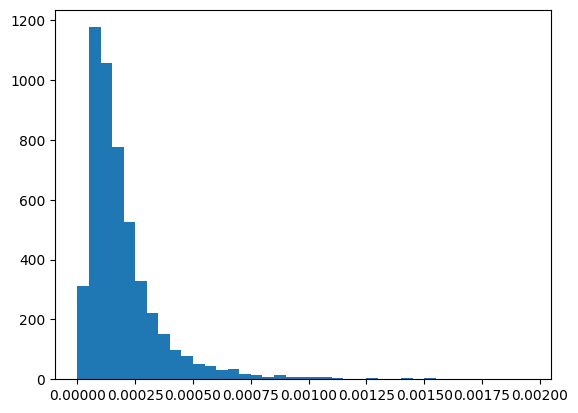

In [35]:
plt.figure()
plt.hist(weights[100], bins=jnp.arange(0, 0.002, 0.00005))
plt.show()

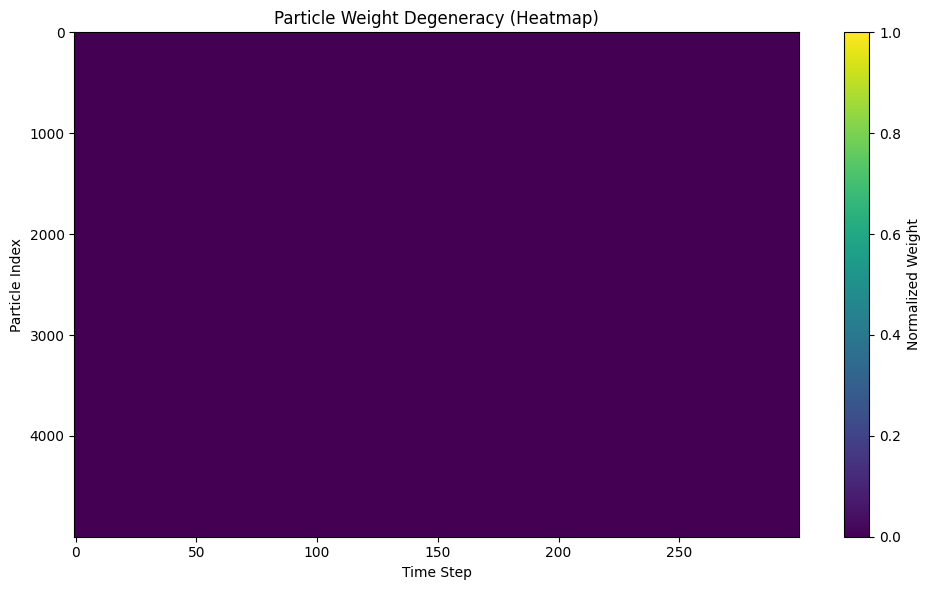

In [21]:
weights = pf_outs.weights[:, :]
T, N = weights.shape

plt.figure(figsize=(10, 6))
plt.imshow(weights.T, aspect='auto', cmap='viridis', interpolation='nearest')

plt.colorbar(label="Normalized Weight")
plt.xlabel("Time Step")
plt.ylabel("Particle Index")
plt.title("Particle Weight Degeneracy (Heatmap)")

plt.tight_layout()
plt.show()

KeyError: 'A'

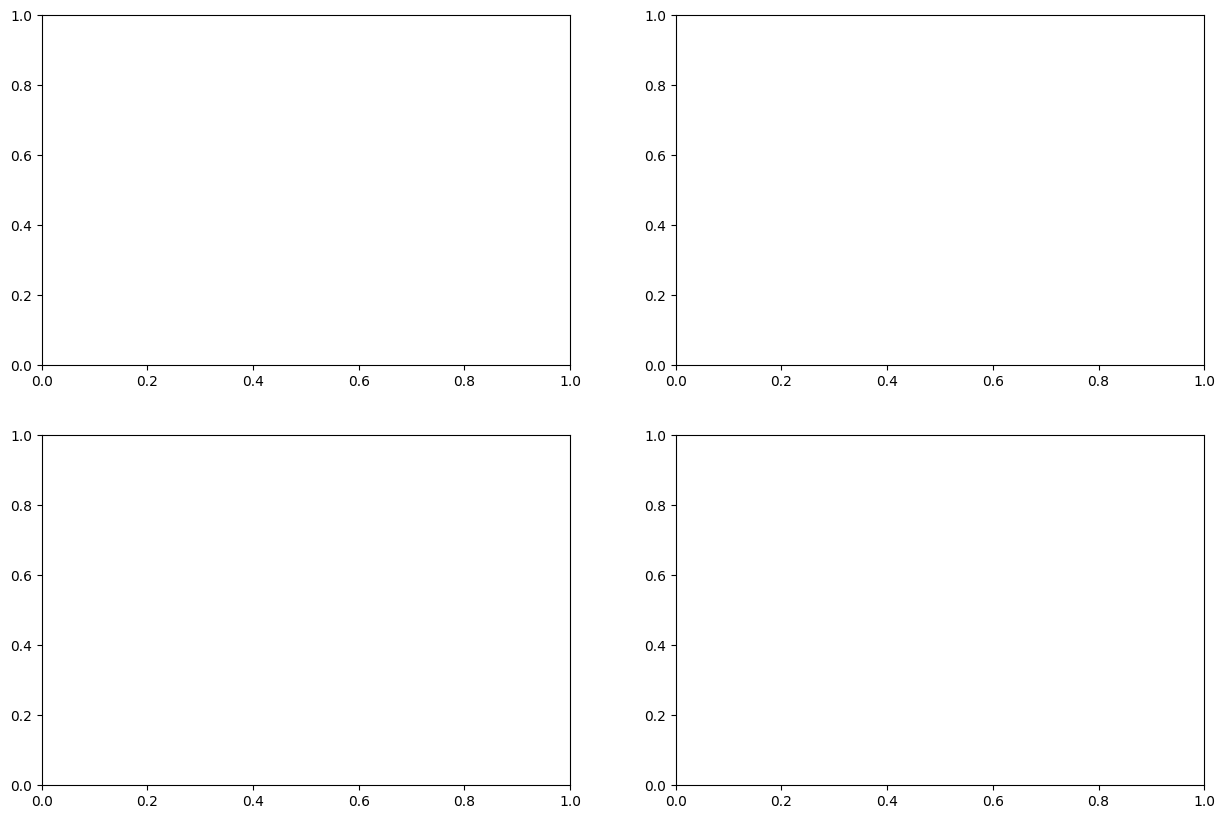

In [14]:
import matplotlib.pyplot as plt

burn_in = 0

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0, 0].plot(((data.params["A"] - pg_samples.thetas["A"])**2)[burn_in:, :, 0])
ax[0, 0].set_title("A")
ax[0, 1].plot(((data.params["Q"] - pg_samples.thetas["Q"])**2)[burn_in:, :, 0])
ax[0, 1].set_title("Q")
ax[1, 0].plot(((data.params["C"] - pg_samples.thetas["C"])**2)[burn_in:, :, 0])
ax[1, 0].set_title("C")
ax[1, 1].plot(((data.params["R"] - pg_samples.thetas["R"])**2)[burn_in:, :, 0])
ax[1, 1].set_title("R")
plt.show()

CSMC weighted x_t shape:  (300, 30)
MSE from CSMC to exact filter means:  0.065550424
MSE from ref to exact filter means:  0.49952105


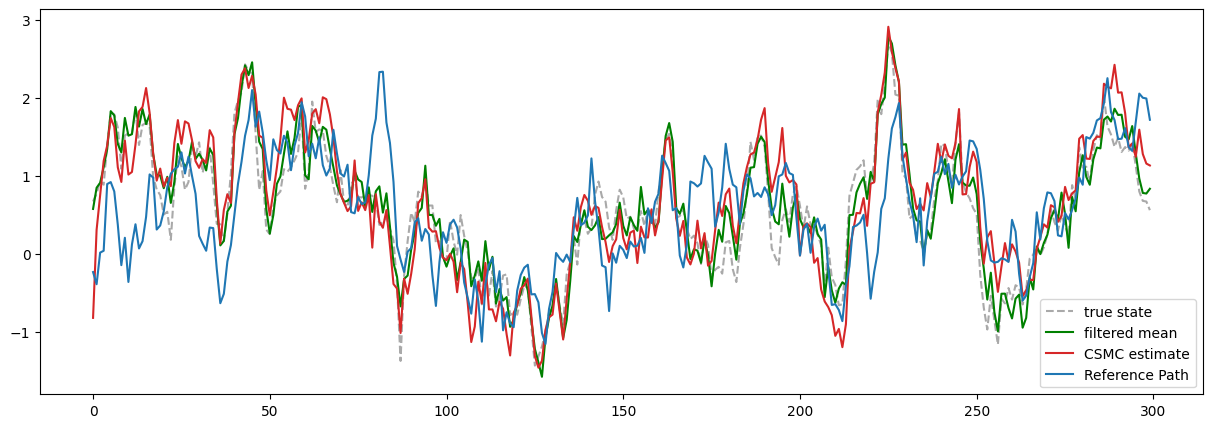

In [36]:

# calculate weighted estimates of state means
x_hat = jnp.sum(pf_outs.weights[:, :, None] * pf_outs.particles, axis=1)
print("CSMC weighted x_t shape: ", x_hat.shape)

# calculate MSE against true filter means
mse_csmc = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
mse_ref = jnp.mean((ref - lgssm_posterior.filtered_means)**2)
print("MSE from CSMC to exact filter means: ", mse_csmc)
print("MSE from ref to exact filter means: ", mse_ref)

# plot results
observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
fig, ax = plt.subplots(figsize=(15, 5))
# ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
# ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
ax.plot(x_hat[:, 3], color="tab:red", label="CSMC estimate")
ax.plot(ref[:, 3], color="tab:blue", label="Reference Path")
plt.legend()
plt.show()
print("\n\n")